In [1]:
###### Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn

import tensorly as tl
from tensorly.cp_tensor import cp_to_tensor
from tensorly import check_random_state

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.stats import pearsonr

import itertools

C:\Users\tesics\AppData\Local\Temp\ipykernel_12208\974682457.py:16: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
###### Import necessary functions
from DATA_PROs_functions import get_feature_mappings, extract_phenotypes, quantify_pt_overlap, quantify_triplet_overlap
from DATA_PROs_functions import explore_membership_values
from DATA_PROs_functions import outcome_by_phenotype, grid_search_models, create_splits
from DATA_PROs_functions import trimmed_rf_model, avg_phenotypes_per_pt, plot_phenotype_importance_scores

from DATA_PROs_plotting import generate_phenotype_time_evolution
from DATA_PROs_plotting import plot_feature_across_phenotypes, plot_trimmed_rf_temporal, compile_results_and_plots

from DATA_PROs_classifier import RF_classifier, plot_rf_feature_importances

from DATA_PROs_model import run_model

In [3]:
###### Set random state and seed (same value)
seed=1221
random_state = 1221 
torch.manual_seed(seed)
rng = check_random_state(random_state)
# device = torch.device("mps")
device = 'cpu'

# Features

In [4]:
static_list=['Prior_med_IFX',
'Prior_med_ADA',
'Prior_med_CZP',
'Prior_med_GOL',
'Prior_med_TOF',
'Prior_med_UPA',
'Prior_med_VDZ',
'Prior_med_UST',
'Current_med_THIO',
'Current_med_MESAL',
'BMI2',
'WeightKG2',
'New_Med_Outcome_yr1',
'age']

In [5]:
lab_list=['Lab_FCP',
'Lab_Hgb',
'Lab_Alb',
'Lab_PLT',
'Lab_Wbc',
'Lab_CRP']

In [6]:
PRO_list=['symptom_bloating',
'symptom_pain',
'symptom_arthritis',
'symptom_urgency',
'symptom_thirsty',
'symptom_tired',
'symptom_weak',
'BM_blood',
'symptom_lackappetite',
'BM_consistancy',
'DA_enjoyment',
'DA_concentrate',
'DA_choirs',
'DA_work',
'DA_travel',
'DA_sleep',
'DA_planning',
'DA_leavinghome',
'DA_sex',
'feeling_alone',
'feeling_angry',
'feeling_depressed',
'feeling_embarrased',
'feeling_frustrated',
'feeling_scared',
'feeling_worried',
'feeling_nocontrol',
'bm_leak',
'bm_mucus']

In [7]:
# Make separate lists for the lab values for each timepoint
lab_list0=[s + '_time_0' for s in lab_list]
lab_listp1=[s + '_time__1' for s in lab_list]
lab_listp2=[s + '_time__2' for s in lab_list]
lab_listp3=[s + '_time__3' for s in lab_list]
lab_lista1=[s + '_time_1' for s in lab_list]
lab_lista2=[s + '_time_2' for s in lab_list]
lab_lista3=[s + '_time_3' for s in lab_list]

# Make separate lists for the symptom scores for each timepoint
PRO_list0=['PRO_' + s + '_Time_0' for s in PRO_list]
PRO_listp1=['PRO_' + s + '_Time_p1' for s in PRO_list]
PRO_listp2=['PRO_' + s + '_Time_p2' for s in PRO_list]
PRO_listp3=['PRO_' + s + '_Time_p3' for s in PRO_list]
PRO_lista1=['PRO_' + s + '_Time_a1' for s in PRO_list]
PRO_lista2=['PRO_' + s + '_Time_a2' for s in PRO_list]
PRO_lista3=['PRO_' + s + '_Time_a3' for s in PRO_list]

In [8]:
# Put all the features together 
feature_list = [lab_list0,lab_listp1,lab_listp2,lab_listp3,lab_lista1,lab_lista2,lab_lista3,
                PRO_list0,PRO_listp1,PRO_listp2,PRO_listp3,PRO_lista1,PRO_lista2,PRO_lista3,
                static_list,['New_Med_Outcome_yr2', 'New_Med_Outcome_yr3']]

feature_list = list(itertools.chain.from_iterable(feature_list))

# Preprocessing

In [9]:
###### Read in data, examine shape, drop majorly empty rows
df = pd.read_excel('DATA_PRO_UC_dataset.xlsx')
df = df[feature_list]

# Encode variables and fill outcomes
df.replace(['not at all', 'a little bit', 'somewhat', 'quite a bit', 'a great deal'],
                        [0, 1, 2, 3, 4], inplace=True)
df.replace(['fail', 'success'],
                        [0, 1], inplace=True)
df['New_Med_Outcome_yr1'] = df['New_Med_Outcome_yr1'].fillna(0)
df['New_Med_Outcome_yr2'] = df['New_Med_Outcome_yr2'].fillna(0)
df['New_Med_Outcome_yr3'] = df['New_Med_Outcome_yr3'].fillna(0)

print(f"Raw data shape is: {df.shape}")
print(f"Raw data fraction of missing values using only desired features is {(df.isna().sum().sum())/(df.shape[0]*df.shape[1])}")
print("Removing patients (rows) that are >= 90% missing values...")
df.dropna(thresh=len(df.columns)*10/100, axis=0, inplace=True)
print(f"Updated fraction of missing values is {(df.isna().sum().sum())/(df.shape[0]*df.shape[1])}")
print(f"Updated data shape is: {df.shape}")

# Set the desired variable lists
print("Setting the desired static, lab, and PRO variables")

# Mean impute for the static variables
df1=df[static_list]
df1=df1.fillna(df1.mean())

# Set static matrix with imputed values
mat=df1[static_list]

# Set desired outcomes
outcome2=df[['New_Med_Outcome_yr2']]
outcome3=df[['New_Med_Outcome_yr3']]

symptom_data = df[PRO_list0+PRO_listp1+PRO_listp2+PRO_listp3+PRO_lista1+PRO_lista2+PRO_lista3]
symptom_tensor = np.stack((df[PRO_list0],df[PRO_listp1],df[PRO_listp2],df[PRO_listp3],df[PRO_lista1],df[PRO_lista2],df[PRO_lista3]), axis=2)
print(symptom_tensor.shape)

# Calculate the number of missing values
num_nan = np.count_nonzero(np.isnan(symptom_tensor))

# Calculate the total number of elements
total_elements = symptom_tensor.size

# Calculate the percentage of missing values
percentage_nan = (num_nan / total_elements) * 100
print(f"The percentage of missing symptom values is {percentage_nan:.2f}%.")

Raw data shape is: (2545, 261)
Raw data fraction of missing values using only desired features is 0.7715752470850364
Removing patients (rows) that are >= 90% missing values...
Updated fraction of missing values is 0.7565860288845301
Updated data shape is: (2303, 261)
Setting the desired static, lab, and PRO variables
(2303, 29, 7)
The percentage of missing symptom values is 88.30%.


In [10]:
count_of_ones = (outcome2.values == 1).sum()
total_count = len(outcome2.values)  
fraction_of_ones = count_of_ones / total_count
print("outcome 2 fraction positive class: ", fraction_of_ones)

count_of_ones = (outcome3.values == 1).sum()
total_count = len(outcome3.values) 
fraction_of_ones = count_of_ones / total_count
print("outcome 2 fraction positive class: ", fraction_of_ones)

outcome 2 fraction positive class:  0.5379939209726444
outcome 2 fraction positive class:  0.4198871037776813


In [11]:
###### Standardize then noramlize 0,1 for static features
scaler = MinMaxScaler()
symptom_scalar = MinMaxScaler((0,1))

col_means = np.mean(mat, axis=0)
col_std_devs = np.std(mat, axis=0, ddof=0)
mat = (mat - col_means) / col_std_devs
mat = symptom_scalar.fit_transform(mat) 

In [12]:
# Format data using the lab values and symptom data
df2=df[lab_list0+lab_listp1+lab_listp2+lab_listp3+lab_lista1+lab_lista2+lab_lista3+
       PRO_list0+PRO_listp1+PRO_listp2+PRO_listp3+PRO_lista1+PRO_lista2+PRO_lista3]
print(df2.shape)

(2303, 245)


In [13]:
# Make slices of the structured data based on timepoint
tens0=df2[lab_list0+PRO_list0]
tens1=df2[lab_lista1+PRO_lista1]
tens2=df2[lab_lista2+PRO_lista2]
tens3=df2[lab_lista3+PRO_lista3]
tens_1=df2[lab_listp1+PRO_listp1]
tens_2=df2[lab_listp2+PRO_listp2]
tens_3=df2[lab_listp3+PRO_listp3]

In [14]:
###### Standardize and normalize each timepoint
tensor_list = [tens0, tens1, tens2, tens3, tens_1, tens_2, tens_3]

# Original, non-normalized, non-scaled data for later use
original_T = np.stack((tens_3,tens_2,tens_1,tens0,tens1,tens2,tens3), axis=2)

for i in range(len(tensor_list)):
    # Standardize each timepoint matrix
    col_means = np.mean(tensor_list[i], axis=0)
    col_std_devs = np.std(tensor_list[i], axis=0, ddof=0)
    tensor_list[i] = (tensor_list[i] - col_means) / col_std_devs

    # Normalize each timepoint
    tensor_list[i] = scaler.fit_transform(tensor_list[i])

# Normalize each timepoint
tens0=scaler.fit_transform(tensor_list[0])
tens1=scaler.fit_transform(tensor_list[1])
tens2=scaler.fit_transform(tensor_list[2])
tens3=scaler.fit_transform(tensor_list[3])
tens_1=scaler.fit_transform(tensor_list[4])
tens_2=scaler.fit_transform(tensor_list[5])
tens_3=scaler.fit_transform(tensor_list[6])

# Create temporal data tensor (T)
T = np.stack((tens_3,tens_2,tens_1,tens0,tens1,tens2,tens3), axis=2)
T.shape, mat.shape

((2303, 35, 7), (2303, 14))

In [15]:
print(f"Updated fraction of missing values in tensor is {np.isnan(T).sum() / T.size}")
print(f"Updated fraction of missing values in matrix is {np.isnan(mat).sum() / mat.size}")

Updated fraction of missing values in tensor is 0.8058149529894458
Updated fraction of missing values in matrix is 0.0


In [16]:
static_mapping, temporal_mapping = get_feature_mappings(static_list, lab_list, PRO_list)

# Set up model with train, validation, and test set

In [17]:
###### Set labels and name data
tl.set_backend('pytorch')
shape = T.shape
Mshape = mat.shape

labels2 = torch.tensor(outcome2.values,dtype=torch.float32).to(device)
labels3 = torch.tensor(outcome3.values,dtype=torch.float32).to(device)
labels = torch.cat([labels2,labels3], axis=1)

tensor = torch.tensor(T, dtype=torch.float32).to(device)
tensor1 = torch.tensor(T, dtype=torch.float32).to(device) # Copy for comparison
Mtensor = torch.tensor(mat, dtype=torch.float32).to(device)

In [18]:
# Split into training, test, and validation set
train_idx, test_idx, val_idx = create_splits(labels2, labels3, device=device, seed=1221)
len(train_idx), len(test_idx), len(val_idx)

(1381, 461, 461)

# Run supervised model, optimizing for rank

In [19]:
###### Run one model and unpack results
relu = nn.ReLU()
results = []

result_dict, hyperparameters_dict = run_model(tensor, tensor1, Mtensor, 
              rng=rng, device=device, 
              train_idx=train_idx, test_idx=test_idx, val_idx=val_idx, labels=labels, 
              rank=28, n_epoch=1400, Lambda=0.7, lr=0.01, 
              penalty_l1=0.001, penalty_l2 = 0, theta = 0.9, grid=False) 


# Unpack results
MAE_val = result_dict['mae']
RMSE_val = result_dict['rmse']
outcome2_auc = result_dict['outcome2_auc']
outcome3_auc = result_dict['outcome3_auc']
rec_loss = result_dict['rec loss']
plot_vals = result_dict['rec loss plot vals']
factor0 = result_dict['pts_x_rank']
factor1 = result_dict['temporal_phenotypes']
mfactor1 = result_dict['static_phenotypes']
factor2 = result_dict['temporal_x_rank']
weights = result_dict['weights']
patient_bias = result_dict['patient bias']
feature_bias = result_dict['feature bias']
reconstruction = relu(cp_to_tensor((weights, [factor0,factor1,factor2])))

outcome2_f1 = result_dict['outcome2_f1'] 
outcome2_recall = result_dict['outcome2_recall']
outcome2_precision = result_dict['outcome2_precision']
outcome3_f1 = result_dict['outcome3_f1']
outcome3_recall = result_dict['outcome3_recall']
outcome3_precision = result_dict['outcome3_precision']

# Unpack hyperparameters
rank = hyperparameters_dict['rank']
original_rank = hyperparameters_dict['rank'] # For later use
n_epoch = hyperparameters_dict['n_epoch']
lr = hyperparameters_dict['lr']
Lambda = hyperparameters_dict['Lambda'] 
penalty_l1 = hyperparameters_dict['penalty_l1'] 
penalty_l2 = hyperparameters_dict['penalty_l2']
alpha = 0.05

results.append((MAE_val.item(), RMSE_val.item(), outcome2_auc, outcome2_f1, outcome2_precision, outcome2_recall, outcome3_auc, outcome3_f1, outcome3_precision, outcome3_recall))
results_df = pd.DataFrame(results, columns=["MAE", "RMSE","AUC_Outcome2", "F1_outcome2", "Precision_outcome2", "Recall_outcome2","AUC_Outcome3",  "F1_outcome3", "Precision_outcome3", "Recall_outcome3"])
print(results_df)

Parameter containing:
tensor([1.0289, 1.0868, 1.0423, 1.0340, 1.0333, 1.0269, 1.0279, 1.0529, 1.0385,
        1.0375, 1.0324, 1.0745, 1.0536, 1.0413, 1.0467, 1.0343, 1.0349, 1.0354,
        1.0425, 1.0458, 1.0427, 1.0428, 1.0265, 1.0354, 1.0302, 1.0463, 1.0600,
        1.0254], requires_grad=True)
        MAE     RMSE  AUC_Outcome2  F1_outcome2  Precision_outcome2  \
0  0.145062  0.19664      0.807152     0.736842            0.770925   

   Recall_outcome2  AUC_Outcome3  F1_outcome3  Precision_outcome3  \
0         0.705645      0.730454     0.508982            0.602837   

   Recall_outcome3  
0         0.440415  


# Visualize patient biases and print out feature biases

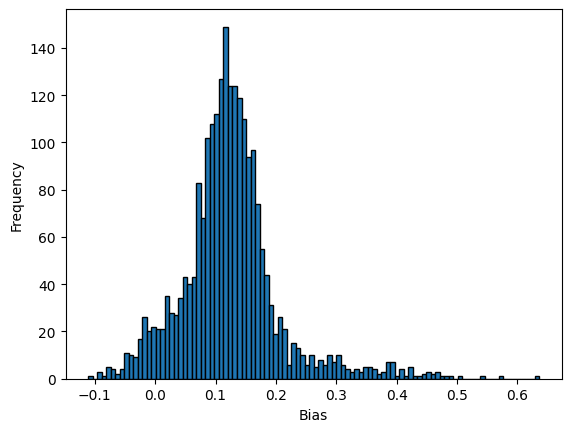

In [20]:
bias_per_pt = patient_bias[:, 0, 0].detach().numpy() 
# Plot the histogram of these values
plt.hist(bias_per_pt, bins=100, edgecolor='black')  
plt.xlabel('Bias')
plt.ylabel('Frequency')
plt.savefig('./final_phenotype_images/patient_bias.png')
plt.show()

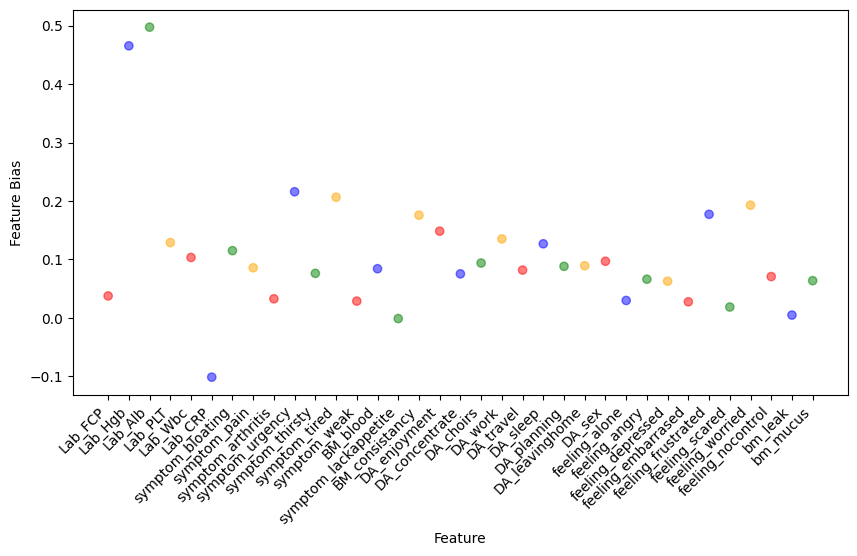

In [21]:
# Pull from first timepoint since same for all times
# Pull from first patient since same for all patients
bias_per_feature = feature_bias[0, :, 0].detach().numpy().flatten() 
feature_indices = np.arange(feature_bias.shape[1])

# Scatter plot
colors = ['red', 'blue', 'green', 'orange']
color_cycle = [colors[i % len(colors)] for i in range(len(feature_indices))]
plt.figure(figsize=(10, 5))
plt.scatter(temporal_mapping.keys(), bias_per_feature, c=color_cycle, alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature Bias')
plt.savefig('./final_phenotype_images/feature_bias.png', bbox_inches='tight')
plt.show()

# RF classifier

In [22]:
# The feature importance NAMES are 1-indexed, indices are zero-indexed
important_indices_1, important_indices_2, importances_df_1, importances_df_2 = RF_classifier(factor0, labels, train_idx, val_idx, test_idx, importance_threshold=0.08) 

filename = "./final_phenotype_images/whole_rank_RF_outcomeyr2_importance_plot.png"
plot_rf_feature_importances(importances_df=importances_df_1, title="", filename=filename)

filename = "./final_phenotype_images/whole_rank_RF_outcomeyr3_importance_plot.png"
plot_rf_feature_importances(importances_df=importances_df_2, title="", filename=filename)

(1842, 28)
(461, 28)
torch.Size([461, 2])
AUC for yr2 outcome: 0.8534
Precision for yr2 outcome: 0.7743
Recall for yr2 outcome: 0.8992
F1 score for yr2 outcome: 0.8321
AUC for yr3 outcome: 0.8030
Precision for yr3 outcome: 0.6459
Recall for yr3 outcome: 0.6995
F1 score for yr3 outcome: 0.6716
AUC for yr2 outcome: 0.8534
AUC for yr3 outcome: 0.8030
Phenotype importances for yr2 outcome:
       Phenotype  Importance
23  Phenotype 24    0.198334
15  Phenotype 16    0.127257
8    Phenotype 9    0.067057
24  Phenotype 25    0.063286
12  Phenotype 13    0.049975
14  Phenotype 15    0.044001
13  Phenotype 14    0.038658
26  Phenotype 27    0.036576
10  Phenotype 11    0.034304
17  Phenotype 18    0.033270
0    Phenotype 1    0.026590
3    Phenotype 4    0.025673
25  Phenotype 26    0.025426
2    Phenotype 3    0.021904
19  Phenotype 20    0.020689
16  Phenotype 17    0.018938
11  Phenotype 12    0.018126
21  Phenotype 22    0.016612
20  Phenotype 21    0.015403
9   Phenotype 10    0.014151
5 

In [23]:
important_indices_1, important_indices_2 # both are zero-indexed

([15, 23], [23, 26])

# Grid search (if desired)

In [24]:
# grid_search_models(tensor, tensor1, Mtensor, rng, device, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx, labels=labels)

# Loss Plot

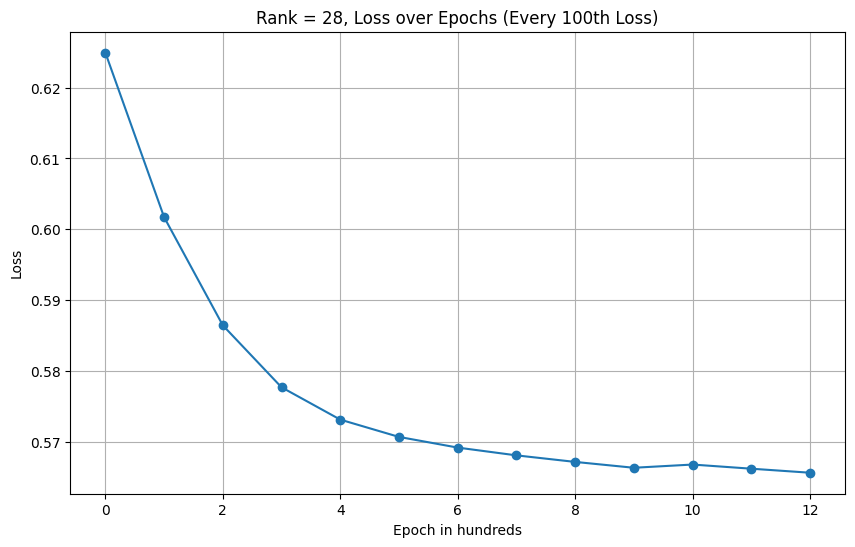

In [25]:
# Plot reconstruction loss across epochs
diagnostic_plot_xvals = np.arange(0, n_epoch, 100)
plt.figure(figsize=(10, 6))
plt.plot(plot_vals, marker='o', linestyle='-')
plt.xlabel('Epoch in hundreds')
plt.ylabel('Loss')
plt.title('Rank = ' + str(rank) + ', Loss over Epochs (Every 100th Loss)')
plt.grid(True)
plt.savefig("./model_diagnostic_images/supervised_model_reconstruction_loss.png")
plt.show()

In [26]:
###### Extract phenotypes
temporal_phenotype_dict = extract_phenotypes(factor1, temporal_mapping, weights, temporal=True, threshold_fraction=0.0)
static_phenotype_dict = extract_phenotypes(mfactor1, static_mapping, weights, temporal=False, threshold_fraction=0.0)

In [27]:
# Outcome year 2 phenotype importance
print("Outcome year 2...")
plot_phenotype_importance_scores(phenotypes=temporal_phenotype_dict, temporal=True, important_indices=important_indices_1)
plot_phenotype_importance_scores(phenotypes=static_phenotype_dict, temporal=False, important_indices=important_indices_1)

print("Outcome year 3...")
plot_phenotype_importance_scores(phenotypes=temporal_phenotype_dict, temporal=True, important_indices=important_indices_2)
plot_phenotype_importance_scores(phenotypes=static_phenotype_dict, temporal=False, important_indices=important_indices_2)

Outcome year 2...
[15, 23]
Plotting the temporal phenotype importance scores for the one-indexed phenotype Phenotype 16
Plotting the temporal phenotype importance scores for the one-indexed phenotype Phenotype 24
[15, 23]
Plotting the static phenotype importance scores for the one-indexed phenotype Phenotype 16
Plotting the static phenotype importance scores for the one-indexed phenotype Phenotype 24
Outcome year 3...
[23, 26]
Plotting the temporal phenotype importance scores for the one-indexed phenotype Phenotype 24
Plotting the temporal phenotype importance scores for the one-indexed phenotype Phenotype 27
[23, 26]
Plotting the static phenotype importance scores for the one-indexed phenotype Phenotype 24
Plotting the static phenotype importance scores for the one-indexed phenotype Phenotype 27


In [28]:
###### Normalize phenotype contribution scores (if desired)
# normalize_phenotypes(temporal_phenotype_dict)
# normalize_phenotypes(static_phenotype_dict)

In [29]:
# Generate time plot for each phenotype
generate_phenotype_time_evolution(rank, factor2)

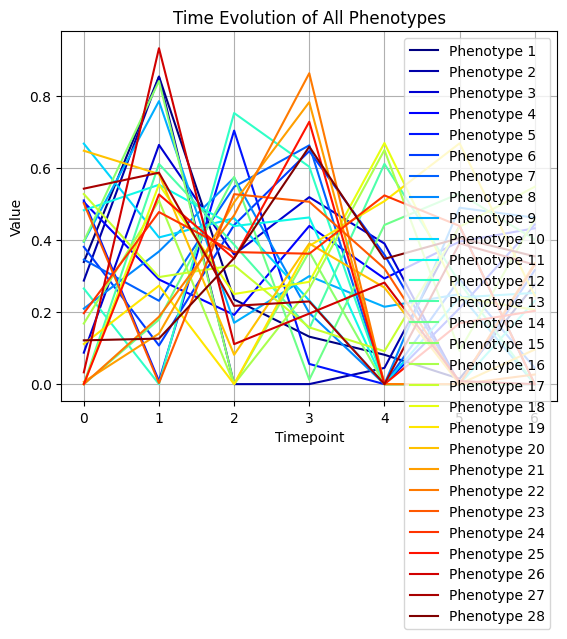

In [30]:
####### Create overlayed time evolution plot
plt.figure()  
colors = plt.cm.jet(np.linspace(0, 1, rank))
for r in range(rank):
    values = factor2[:, r]
    plt.plot(values.detach().numpy(), label=f"Phenotype {r + 1}", color=colors[r])

plt.title("Time Evolution of All Phenotypes")
plt.xlabel("Timepoint")
plt.ylabel("Value")
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig("./model_diagnostic_images/time_evolution_all_phenotypes.png")
plt.show()

In [31]:
explore_membership_values(final_phenotype_indices_outcome1=important_indices_1,
                            final_phenotype_indices_outcome2=important_indices_2,
                            factor0=factor0)

Phenotype 15
Mean: 0.01917979121208191
Median: 0.019983356818556786
Standard Deviation: 0.009492408484220505
60th Percentile: 0.022234493121504783
75th Percentile: 0.02557869628071785
Phenotype 23
Mean: 0.01887151598930359
Median: 0.0200990978628397
Standard Deviation: 0.010148090310394764
60th Percentile: 0.022330905124545098
75th Percentile: 0.02552495989948511
Phenotype 26
Mean: 0.019343333318829536
Median: 0.020144999027252197
Standard Deviation: 0.010125018656253815
60th Percentile: 0.022349366173148155
75th Percentile: 0.02625763602554798


In [32]:
# How many phenotypes on average a patient belongs to
avg_phenotypes_per_patient = avg_phenotypes_per_pt(factor0)
print(avg_phenotypes_per_patient)

7.003039360046387


Random Forest on Final Phenotypes

NOTE: trimmed_rf_model trains for both outcomes. So, when you are interested in the top phenotypes only for outcome year 2, ignore the function output for outcome year 3, and the opposite when you are interested in the top phenotypes specific to outcome year 3. 

In [34]:
print("Outcome 2 final RF (ignore printed results for outcome 3)")
_, importances_df_1, _ = trimmed_rf_model(factor0=factor0, 
                        factor2=factor2,
                        original_data=T, 
                        rf_shortened_phenotype_indices=important_indices_1, 
                        temporal_phenotype_dict=temporal_phenotype_dict, 
                        temporal_mapping=temporal_mapping,
                        labels=labels, 
                        train_idx=train_idx, 
                        val_idx=val_idx,
                        test_idx=test_idx,
                        static_list=static_list,
                        lab_list=lab_list,
                        PRO_list=PRO_list)

filename = "./final_phenotype_images/trimmed_RF_outcomeyr2_importance_plot.png"
plot_rf_feature_importances(importances_df=importances_df_1, title="", filename=filename)

print("Outcome 3 final RF (ignore printed results for outcome 2)")
_, _, importances_df_2 = trimmed_rf_model(factor0=factor0, 
                        factor2=factor2, 
                        original_data=T,
                        rf_shortened_phenotype_indices=important_indices_2, 
                        temporal_phenotype_dict=temporal_phenotype_dict, 
                        temporal_mapping=temporal_mapping,
                        labels=labels, 
                        train_idx=train_idx, 
                        val_idx=val_idx,
                        test_idx=test_idx,
                        static_list=static_list,
                        lab_list=lab_list,
                        PRO_list=PRO_list)

filename = "./final_phenotype_images/trimmed_RF_outcomeyr3_importance_plot.png"
plot_rf_feature_importances(importances_df=importances_df_2, title="", filename=filename)

plot_trimmed_rf_temporal(final_phenotype_indices_outcome1=important_indices_1,
                         final_phenotype_indices_outcome2=important_indices_2,
                         factor2=factor2)

Outcome 2 final RF (ignore printed results for outcome 3)
Invalid divide encountered for avg patient plotting
Invalid divide encountered for avg patient plotting
[15, 23]
(1842, 2)
(461, 2)
torch.Size([461, 2])
AUC for yr2 outcome: 0.8117
Precision for yr2 outcome: 0.7599
Recall for yr2 outcome: 0.8548
F1 score for yr2 outcome: 0.8046
AUC for yr3 outcome: 0.7376
Precision for yr3 outcome: 0.5822
Recall for yr3 outcome: 0.6788
F1 score for yr3 outcome: 0.6268
AUC for yr2 outcome: 0.8117
AUC for yr3 outcome: 0.7376
Phenotype importances for yr2 outcome:
     Phenotype  Importance
1  Phenotype 2    0.560702
0  Phenotype 1    0.439298
Phenotype importances for yr3 outcome:
     Phenotype  Importance
1  Phenotype 2    0.588778
0  Phenotype 1    0.411222
RF1
RandomForestClassifier(random_state=42)
RF2
RandomForestClassifier(random_state=42)
Outcome 3 final RF (ignore printed results for outcome 2)
Invalid divide encountered for avg patient plotting
Invalid divide encountered for avg patient 

In [35]:
# Plot top temporal features across phenotypes for easy visual comparison
plot_feature_across_phenotypes(factor0, temporal_mapping, original_T)

In [36]:
important_indices_1, important_indices_2

([15, 23], [23, 26])

# Save all the results to an excel file

In [37]:
compile_results_and_plots(temporal_phenotype_dict, static_phenotype_dict, results_df,
                              n_epoch, original_rank, rank, Lambda, lr, penalty_l1, penalty_l2,
                              lab_list, factor1, df, factor0)